In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import joblib # <--- ADD THIS LINE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Needed for isinstance check
from sklearn.model_selection import train_test_split # Needed for re-splitting data
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

print("📊 Deep Model Evaluation Phase Started!")
print("📚 Libraries loaded successfully!")

📊 Deep Model Evaluation Phase Started!
📚 Libraries loaded successfully!


In [2]:
# Load saved model components and test data
print("💾 Loading best model, scaler, feature columns, and test data...")

try:
    best_model = joblib.load('../models/best_model.pkl')
    scaler = joblib.load('../models/scaler.pkl')
    feature_columns = joblib.load('../models/feature_columns.pkl')
    
    # Load X_full and y_full from processed data
    X_full = pd.read_csv('../data/processed/X_features.csv')
    y_full = pd.read_csv('../data/processed/y_target.csv').squeeze()
    
    # Re-split to get consistent X_test, y_test with model training
    # This ensures the test set is exactly what the model was evaluated on in Phase 3
    _, X_test, _, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

    # Scale X_test using the loaded scaler
    # Check if the model expects scaled data (e.g., Logistic Regression) using its type
    if isinstance(best_model, (LogisticRegression)):
        X_test_processed = scaler.transform(X_test)
    else:
        X_test_processed = X_test # Tree-based models (XGBoost, RF, GB) don't need scaling

    print("✅ Components and test data loaded successfully!")
    print(f"🏆 Best Model: {type(best_model).__name__}")
    print(f"📊 X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

except FileNotFoundError:
    print("❌ Error: Model components or processed data not found. Please run Phase 3 notebook first.")
    exit()
except Exception as e:
    print(f"❌ An error occurred during loading: {e}")
    # This will print the actual error if it's not FileNotFoundError
    exit()

💾 Loading best model, scaler, feature columns, and test data...
✅ Components and test data loaded successfully!
🏆 Best Model: LGBMClassifier
📊 X_test shape: (12090, 42), y_test shape: (12090,)


## 🚀 Step 1: Make Predictions and Evaluate

In [3]:
# Make predictions on the test set
print("🚀 Making predictions on the test set...")
y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

# Evaluate performance
print("\n📊 Model Performance on Test Set:")
print(f"AUC: {auc(roc_curve(y_test, y_pred_proba)[0], roc_curve(y_test, y_pred_proba)[1]):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

🚀 Making predictions on the test set...

📊 Model Performance on Test Set:
AUC: 0.9209

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     10755
           1       0.39      0.86      0.53      1335

    accuracy                           0.83     12090
   macro avg       0.68      0.84      0.72     12090
weighted avg       0.91      0.83      0.86     12090



## 📈 Step 2: Confusion Matrix Visualization

📈 Visualizing Confusion Matrix...


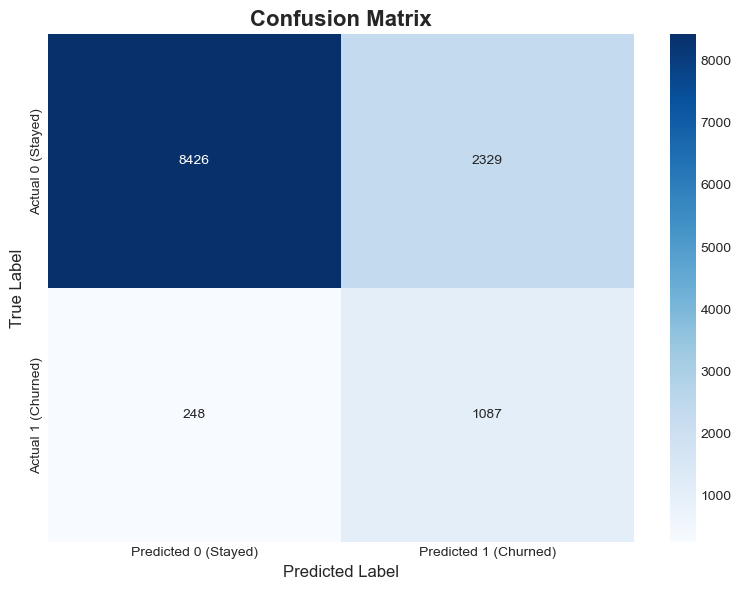


🎯 Confusion Matrix Insights:
   True Negatives (Correctly predicted stayed): 8,426
   False Positives (Predicted churned, but stayed): 2,329
   False Negatives (Predicted stayed, but churned): 248
   True Positives (Correctly predicted churned): 1,087
   -----------------------------------------
   Accuracy: 0.7868
   Precision (of predicted churn): 0.3182
   Recall (of actual churn): 0.8142


In [4]:
# Plot Confusion Matrix
print("📈 Visualizing Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0 (Stayed)', 'Predicted 1 (Churned)'],
            yticklabels=['Actual 0 (Stayed)', 'Actual 1 (Churned)']) # Changed labels for clarity
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n🎯 Confusion Matrix Insights:")
print(f"   True Negatives (Correctly predicted stayed): {cm[0,0]:,}")
print(f"   False Positives (Predicted churned, but stayed): {cm[0,1]:,}")
print(f"   False Negatives (Predicted stayed, but churned): {cm[1,0]:,}")
print(f"   True Positives (Correctly predicted churned): {cm[1,1]:,}")
print("   -----------------------------------------")
print(f"   Accuracy: {(cm[0,0] + cm[1,1]) / cm.sum():.4f}")
print(f"   Precision (of predicted churn): {cm[1,1] / (cm[0,1] + cm[1,1]):.4f}")
print(f"   Recall (of actual churn): {cm[1,1] / (cm[1,0] + cm[1,1]):.4f}")

## 📉 Step 3: Precision-Recall Curve (Crucial for Imbalanced Data)

📉 Visualizing Precision-Recall Curve...


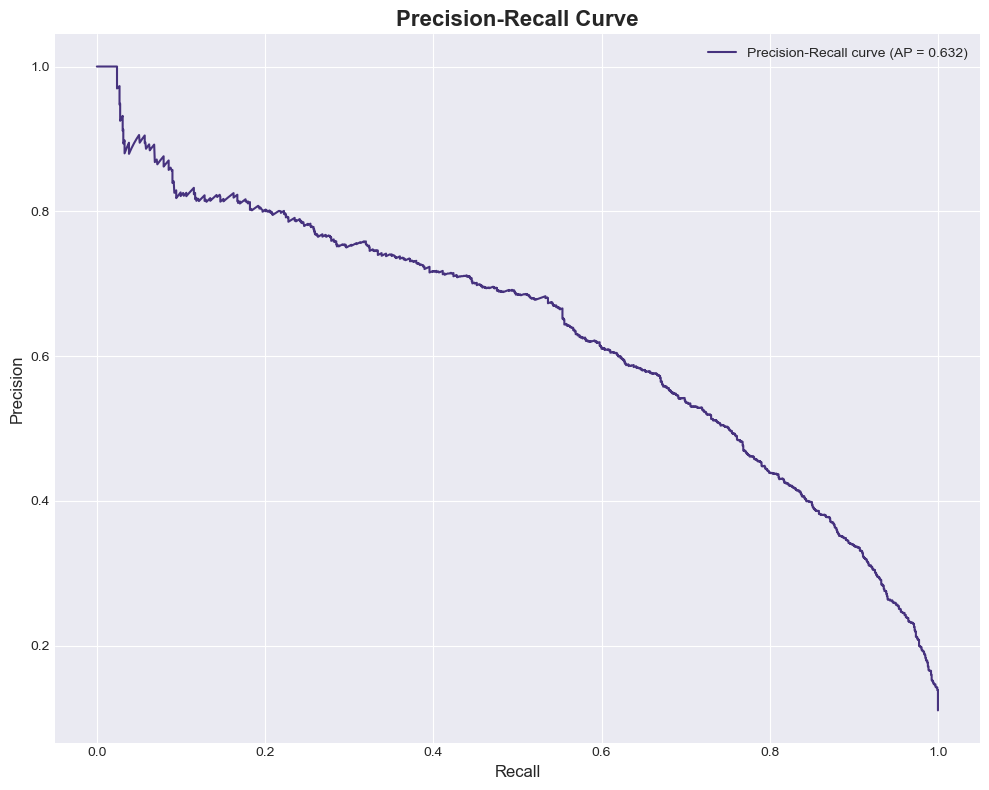

✅ Precision-Recall curve generated successfully!
🎯 Average Precision (AP) is a good summary metric for imbalanced classification.


In [4]:
# Plot Precision-Recall Curve
print("📉 Visualizing Precision-Recall Curve...")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Precision-Recall curve generated successfully!")
print("🎯 Average Precision (AP) is a good summary metric for imbalanced classification.")

## 📈 Step 4: Feature Importance Analysis (Revisited)


📈 Analyzing Feature Importance for the Best Model...


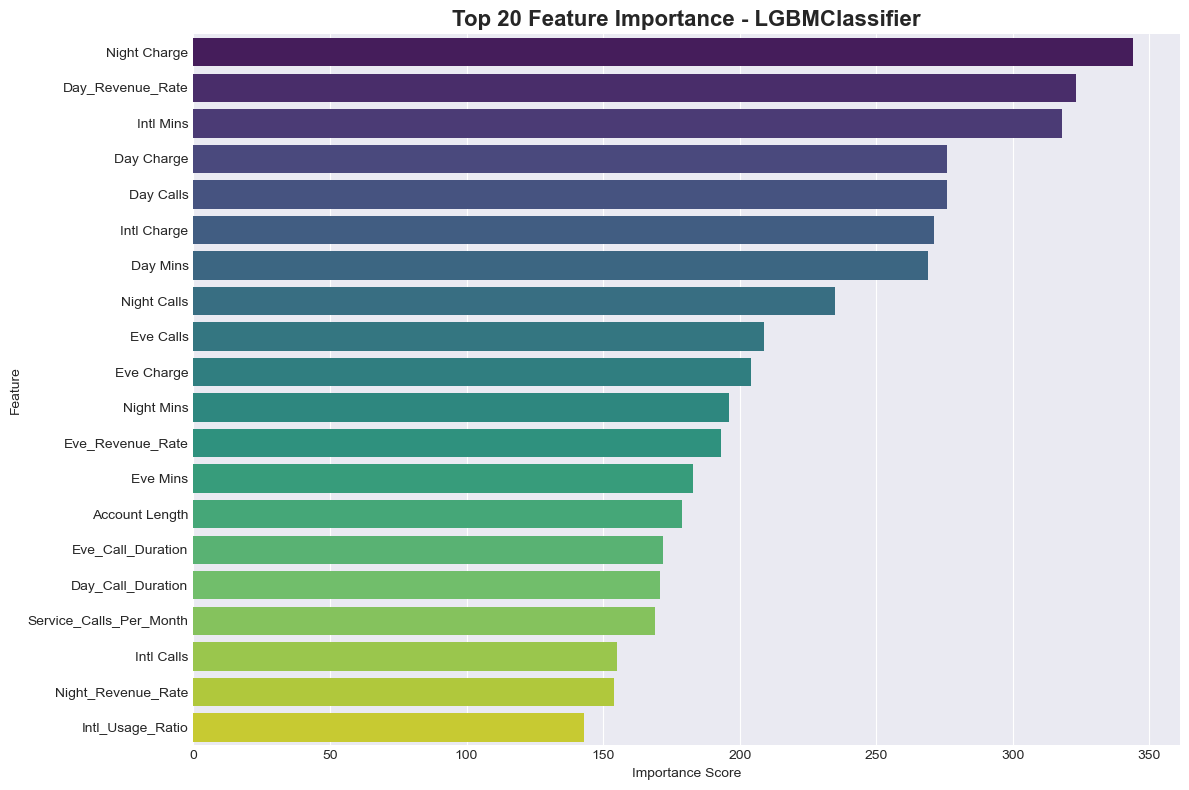


📋 Top 10 Most Important Features:


,feature,importance
10,Night Charge,344
27,Day_Revenue_Rate,323
11,Intl Mins,318
4,Day Charge,276
3,Day Calls,276
13,Intl Charge,271
2,Day Mins,269
9,Night Calls,235
6,Eve Calls,209
7,Eve Charge,204


In [5]:
# Re-analyze Feature Importance (if available for the best model)
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Analyzing Feature Importance for the Best Model...")
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
    plt.title(f'Top 20 Feature Importance - {type(best_model).__name__}', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print("\n📋 Top 10 Most Important Features:")
    display(feature_importance.head(10))
else:
    print("\n⚠️ Feature importance not available for selected model (e.g., Logistic Regression).")